# Baselines

In [8]:
import os
import sys
from collections import defaultdict
from multiprocessing import Pool
import snap
import matplotlib.pyplot as plt
from IPython.display import Image
import operator

src_hash_dir = 'mag_src_hash'
dst_hash_dir = 'mag_dst_hash'

buckets = 3000

## Process.py

In [9]:
def paper_id_to_src_file(paper_id):
    return os.path.join(src_hash_dir, '{:04d}.txt'.format(paper_id % buckets))


def paper_id_to_dst_file(paper_id):
    return os.path.join(dst_hash_dir, '{:04d}.txt'.format(paper_id % buckets))


def merge_dicts(dicts):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.

    From: https://stackoverflow.com/a/26853961
    """
    result = defaultdict(set)
    for dictionary in dicts:
        for key in dictionary:
            result[key] |= dictionary[key]
    return result


def get_in_refs_in_file((ref_filename, paper_id_set)):
    paper_to_refs = defaultdict(set)
    with open(ref_filename, 'r') as reference_file:
        for line in reference_file:
            ids = line.split()
            src_id = int(ids[0])
            dst_id = int(ids[1])

            if src_id in paper_id_set:
                paper_to_refs[src_id].add(dst_id)
    return paper_to_refs


def get_out_refs_in_file((ref_filename, paper_id_set)):
    paper_to_refs = defaultdict(set)
    with open(ref_filename, 'r') as reference_file:
        for line in reference_file:
            ids = line.split()
            src_id = int(ids[0])
            dst_id = int(ids[1])

            if dst_id in paper_id_set:
                paper_to_refs[src_id].add(dst_id)
    return paper_to_refs


def get_references(paper_ids, follow_in=True, follow_out=False, p=Pool(4)):

    in_results = []
    if follow_in:
        src_files_to_papers = defaultdict(set)
        for paper_id in paper_ids:
            src_files_to_papers[paper_id_to_src_file(paper_id)].add(paper_id)
        in_results += p.map(get_in_refs_in_file, src_files_to_papers.items())

    out_results = []
    if follow_out:
        dst_files_to_papers = defaultdict(set)
        for paper_id in paper_ids:
            dst_files_to_papers[paper_id_to_dst_file(paper_id)].add(paper_id)
        out_results += p.map(get_out_refs_in_file, dst_files_to_papers.items())

    return merge_dicts(in_results), merge_dicts(out_results)


def bfs(init_paper, follow_in=True, follow_out=False, levels=1):
    papers_to_references = defaultdict(list)
    pool = Pool(4)
    current_level = set([init_paper])
    for i in range(0, levels):
        paper_ref_level_in, paper_ref_level_out =\
            get_references(current_level, follow_in, follow_out, pool)
        
        current_level = set()
        for papers in paper_ref_level_in.values():
            for paper in papers:
                if paper not in papers_to_references:
                    current_level.add(paper)
        for paper in paper_ref_level_out.keys():
            if paper not in papers_to_references:
                current_level.add(paper)
        
        papers_to_references = merge_dicts(
            [papers_to_references, paper_ref_level_in, paper_ref_level_out])
            
    return papers_to_references


def get_bfs_results(start_paper, follow_in=True, follow_out=False, levels=1):
    print("Running {} level bfs starting from paper id: {}".format(
        levels, start_paper))
    results = bfs(start_paper, follow_in, follow_out, levels)
    print(results)
    print("found {} nodes".format(len(results.keys())))
    print("found {} edges".format(
        sum([len(neighbors) for neighbors in results.values()])))
    return results

In [3]:
results = get_bfs_results(633000, True, True, 3)

Running 3 level bfs starting from paper id: 633000
defaultdict(<type 'set'>, {2308259847: set([2298618108]), 2403008523: set([2212104334]), 1600875181: set([2111796094]), 2786680193: set([2111796094]), 2408527192: set([1495720156]), 1591525394: set([2289762085]), 1937399827: set([1523775595]), 2205917206: set([2212104334]), 961587565: set([51873122]), 1956339736: set([2111796094]), 1532289050: set([1509685449]), 1538411183: set([2111796094]), 2400873136: set([2111796094]), 2408431650: set([2111796094]), 2511429667: set([1495720156]), 2274066470: set([2111796094]), 2285748265: set([2111796094]), 2394497067: set([2111796094]), 1604829228: set([1745163459]), 2260508721: set([2417365778]), 2230665269: set([2111796094]), 2246729782: set([1544109639]), 2396528696: set([2111796094]), 942456889: set([1957088915]), 2272477244: set([2111796094]), 2410061885: set([2111796094]), 2401673279: set([24771121]), 1534025793: set([2116295480]), 1524303201: set([1025550518]), 2297446473: set([2111796094])

In [13]:
only_out_results = get_bfs_results(633000, True, False, 3)

Running 3 level bfs starting from paper id: 633000
defaultdict(<type 'set'>, {2243551393: set([2297366377, 2141927227]), 2340983618: set([2286589455]), 2246427555: set([2827569257]), 2275125910: set([2249712656, 2871071345, 2408769820, 2275518269]), 1544109639: set([2254120704, 2198619393, 2253358471, 2240665614, 2243642157, 2275705878, 2399686301, 2098146462, 2197373601, 93050404, 2433164325, 1872434601, 2407083179, 978468397, 2212461742, 2285500829, 2230621872, 153565618, 1479859315, 2408792631, 1519333560, 2249772093, 2544041743, 2248518597, 2242678497, 2249354699, 2252831948, 2248234959, 2599767736, 1978310876, 87417359, 1503781293, 2407362395, 1423986140, 2398006753, 2784133859, 2270287076, 1505795945, 2415032429, 2397969518, 2273321329, 2309350387, 2009442552, 2818849537]), 633000: set([2243551393, 1493743244, 2261323244, 2265547382]), 2261323244: set([2141927227]), 1493743244: set([2340983618, 2246427555, 1544109639, 2410206514, 2417365778, 2275125910, 1496099962, 2291169085]), 

## Create SNAP Graph

In [10]:
def translate(mag_to_snap, mag_id, Graph):
    if mag_id not in mag_to_snap:
        mag_to_snap[mag_id] = Graph.AddNode()
    return mag_to_snap[mag_id]

def create_subgraph(start_paper, results, save_path):
    Graph = snap.TNGraph.New()
    mag_to_snap = {}
    for paper in results:
        references = results[paper]
        paper_nid = translate(mag_to_snap, paper, Graph)
        for reference in references:
            ref_nid = translate(mag_to_snap, reference, Graph)                
            # Switch edge ordering if want b->a if a cites b
            # Right now, has edge a->b if a cites b
            if not Graph.IsEdge(paper_nid, ref_nid):
                Graph.AddEdge(paper_nid, ref_nid)
    print("graph has {} nodes".format(Graph.GetNodes()))
    print("graph has {} edges".format(Graph.GetEdges()))
    
    # Save SNAP graph to binary file
    FOut = snap.TFOut(save_path)
    Graph.Save(FOut)
    FOut.Flush()
    
    return Graph, mag_to_snap

In [11]:
Graph, mag_to_snap = create_subgraph(633000, results, "full_bfs.graph")
snap_to_mag = {v: k for k, v in mag_to_snap.iteritems()}

graph has 6443 nodes
graph has 7053 edges


In [14]:
OutGraph, mag_to_snap_out = create_subgraph(633000, only_out_results, "out_bfs.graph")
snap_to_mag_out = {v: k for k, v in mag_to_snap_out.iteritems()}

graph has 109 nodes
graph has 112 edges


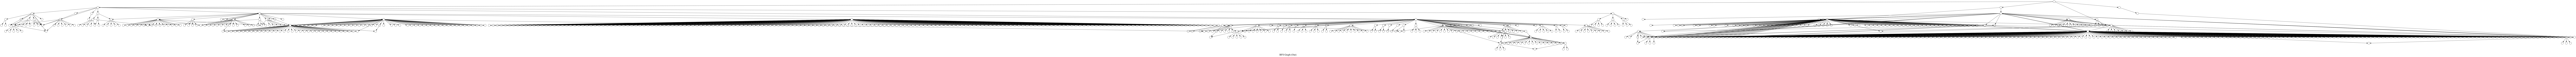

In [99]:
# Display graph
snap.DrawGViz(OutGraph, snap.gvlDot, "out_graph.png", "BFS Graph (Out)")
Image(filename='out_graph.png')

In [ ]:
# Sanity check
start_node = Graph.GetNI(mag_to_snap[633000])
print("633000 has {} references in full BFS graph".format(start_node.GetOutDeg()))
print("633000 has {} citations in full BFS graph".format(start_node.GetInDeg()))

## Baselines

### PageRank

In [ ]:
# FULL BFS GRAPH
PRankH = snap.TIntFltH()
snap.GetPageRank(Graph, PRankH)
PRankH.SortByDat(False)
pagerank_scores = [(snap_to_mag[item], PRankH[item]) for item in PRankH]
print "TOP PAGERANK (FULL):"
for a in pagerank_scores[:5]:
    print a

In [ ]:
# OUT BFS GRAPH
PRankH = snap.TIntFltH()
snap.GetPageRank(OutGraph, PRankH)
PRankH.SortByDat(False)
pagerank_scores = [(snap_to_mag_out[item], PRankH[item]) for item in PRankH]
print "TOP PAGERANK (OUT):"
for a in pagerank_scores[:5]:
    print a

### Hubs and Authorities

In [ ]:
NIdHubH = snap.TIntFltH()
NIdAuthH = snap.TIntFltH()
snap.GetHits(Graph, NIdHubH, NIdAuthH)
NIdHubH.SortByDat(False)
NIdAuthH.SortByDat(False)

hub_scores = [(snap_to_mag[item], NIdHubH[item]) for item in NIdHubH]
authority_scores = [(snap_to_mag[item], NIdAuthH[item]) for item in NIdAuthH]
print "TOP HUBS:"
for a in hub_scores[:5]:
    print a
    
print "TOP AUTHORITIES:"
for a in authority_scores[:5]:
    print a

### Node In Degree (Number of Citations)

In [ ]:
InDegV = snap.TIntPrV()
snap.GetNodeInDegV(Graph, InDegV)
in_degrees = [(snap_to_mag[item.GetVal1()], item.GetVal2()) for item in InDegV]
in_degrees.sort(key=operator.itemgetter(1), reverse=True)
print "PAPERS WITH MOST CITATIONS:"
for a in in_degrees[:5]:
    print a

### Node Out Degree (Number of References)

In [ ]:
OutDegV = snap.TIntPrV()
snap.GetNodeOutDegV(Graph, OutDegV)
out_degrees = [(snap_to_mag[item.GetVal1()], item.GetVal2()) for item in OutDegV]
out_degrees.sort(key=operator.itemgetter(1), reverse=True)
print "PAPERS WITH MOST REFERENCES:"
for a in out_degrees[:10]:
    print a

## Search Path Count (SPC)

In [15]:
def get_in_degrees(Graph):
    InDegV = snap.TIntPrV()
    snap.GetNodeInDegV(Graph, InDegV)
    return {item.GetVal1() : item.GetVal2() for item in InDegV}

def get_out_degrees(Graph):
    OutDegV = snap.TIntPrV()
    snap.GetNodeOutDegV(Graph, OutDegV)
    return {item.GetVal1() : item.GetVal2() for item in OutDegV}

In [20]:
def compute_n_minus(start, in_degrees, Graph):
    n_minus = defaultdict(int)
    in_deg = in_degrees.copy()
    while len(start) > 0:
        node = start.pop()
        print "looking at node", node
        if in_degrees[node] == 0:
            n_minus[node] = 1
        else:
            total = 0
            for citation in Graph.GetNI(node).GetInEdges():
                total += n_minus[citation]
            n_minus[node] = total

        for ref in Graph.GetNI(node).GetOutEdges():
            in_deg[ref] -= 1
            if in_deg[ref] == 0:
                start.add(ref)
                print "... added", ref
            else:
                print "... skipping", ref, "still has ", in_deg[ref], " in edges"
                print "......", list(Graph.GetNI(ref).GetInEdges())
    return n_minus

In [21]:
def compute_n_plus(start, out_degrees, Graph):
    n_plus = defaultdict(int)
    out_deg = out_degrees.copy()
    while len(start) > 0:
        node = start.pop()
        if out_degrees[node] == 0:
            n_plus[node] = 1
        else:
            total = 0
            for reference in Graph.GetNI(node).GetOutEdges():
                total += n_plus[reference]
            n_plus[node] = total

        for citation in Graph.GetNI(node).GetInEdges():
            out_deg[citation] -= 1
            if out_deg[citation] == 0:
                start.add(citation)
    return n_plus

In [22]:
def spc(Graph):
    in_degrees = get_in_degrees(Graph)
    out_degrees = get_out_degrees(Graph)
    
    n_minus = compute_n_minus(set([node for node in in_degrees if in_degrees[node] == 0]), in_degrees, Graph)
    n_plus = compute_n_plus(set([node for node in out_degrees if out_degrees[node] == 0]), out_degrees, Graph)
    
    spc_counts = defaultdict(int)
    for edge in Graph.Edges():
        src = edge.GetSrcNId()
        dst = edge.GetDstNId()
        spc_counts[(src, dst)] = n_minus[src] * n_plus[dst]
    return spc_counts

In [23]:
spc_counts = spc(OutGraph)

looking at node 57
... added 0
... added 58
... added 59
... added 60
looking at node 0
... added 1
... skipping 2 still has  1  in edges
...... [0, 59]
looking at node 1
looking at node 58
... added 3
... added 5
... added 7
... skipping 12 still has  1  in edges
...... [58, 61]
... added 61
... added 62
... skipping 63 still has  1  in edges
...... [58, 64]
... added 64
looking at node 64
... added 63
... added 101
... added 102
... added 103
... added 104
... added 105
... added 106
... added 107
... added 108
looking at node 3
... added 4
looking at node 4
looking at node 5
... added 6
looking at node 102
looking at node 7
... added 8
... added 9
... added 10
... added 11
looking at node 104
looking at node 105
looking at node 106
looking at node 103
looking at node 108
looking at node 101
looking at node 8
looking at node 10
looking at node 107
looking at node 9
looking at node 59
... added 2
looking at node 2
... added 84
... added 85
... added 86
... added 87
... added 88
... ad

In [30]:
print snap_to_mag_out[0]
print snap_to_mag_out[59]
print(len(spc_counts))

2243551393
2261323244
112


### Running SPC Count on Test Graph
From https://en.wikipedia.org/wiki/Main_path_analysis#/media/File:SPC_values_for_a_citation_network.png

In [79]:
TestGraph = snap.TNGraph.New()
for i in xrange(14):
    TestGraph.AddNode(i)
edges = [(0, 2), (1, 2), (1, 3), (2, 4), (4, 6), (6, 7), (2, 7), (3, 5),\
         (3, 8), (5, 8), (5, 7), (1, 9), (7, 10), (8, 11), (8, 12), (9, 12), (12, 13)]
for edge in edges:
    TestGraph.AddEdge(edge[0], edge[1])

In [ ]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
spc_counts = spc(TestGraph)
for edge in spc_counts:
    print alphabet[edge[0]], "->", alphabet[edge[1]], ":", spc_counts[edge]

## Main Path Analysis

In [27]:
def mpa(start_node, translate, Graph):
    spc_counts = spc(Graph)
    print(spc_counts)
    node = start_node
    print "Starting at node", translate[node]
    while Graph.GetNI(node).GetOutDeg() != 0:
        next_node = -1
        largest_spc = -1
        for neighbor in Graph.GetNI(node).GetOutEdges():
            if spc_counts[(node, neighbor)] > largest_spc:
                largest_spc = spc_counts[(node, neighbor)]
                next_node = neighbor
        node = next_node
        print "... going to node", translate[node], "with spc", largest_spc

In [98]:
mpa(1, alphabet, TestGraph)

defaultdict(<type 'int'>, {(1, 2): 2, (2, 7): 2, (1, 3): 5, (6, 7): 2, (4, 6): 2, (8, 12): 2, (12, 13): 3, (8, 11): 2, (5, 7): 1, (0, 2): 2, (3, 8): 2, (1, 9): 1, (7, 10): 5, (9, 12): 1, (2, 4): 2, (5, 8): 2, (3, 5): 3})
Starting at node b
... going to node d with spc 5
... going to node f with spc 3
... going to node i with spc 2
... going to node l with spc 2


In [28]:
mpa(mag_to_snap_out[633000], snap_to_mag_out, OutGraph)

looking at node 57
... added 0
... added 58
... added 59
... added 60
looking at node 0
... added 1
... skipping 2 still has  1  in edges
...... [0, 59]
looking at node 1
looking at node 58
... added 3
... added 5
... added 7
... skipping 12 still has  1  in edges
...... [58, 61]
... added 61
... added 62
... skipping 63 still has  1  in edges
...... [58, 64]
... added 64
looking at node 64
... added 63
... added 101
... added 102
... added 103
... added 104
... added 105
... added 106
... added 107
... added 108
looking at node 3
... added 4
looking at node 4
looking at node 5
... added 6
looking at node 102
looking at node 7
... added 8
... added 9
... added 10
... added 11
looking at node 104
looking at node 105
looking at node 106
looking at node 103
looking at node 108
looking at node 101
looking at node 8
looking at node 10
looking at node 107
looking at node 9
looking at node 59
... added 2
looking at node 2
... added 84
... added 85
... added 86
... added 87
... added 88
... ad

In [101]:
in_degrees = get_in_degrees(OutGraph)
set([snap_to_mag_out[node] for node in in_degrees if in_degrees[node] == 0])

{633000}